In [1]:
# Load a few packages first 

In [2]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from evaluate import evaluate
from unet import UNet
from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss

In [8]:
#dir_img = Path('./data/imgs/')
#dir_mask = Path('./data/masks/')
#dir_checkpoint = Path('./checkpoints/')


dir_img = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-02/test/img/'
dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-02/test/Diffusion/'


In [4]:
from datetime import datetime
 # Define the base path
base_path = 'Z:/Dongyu Fan/2. Data/ImageProcessing/training'
# Get current date and time
now = datetime.now()
date_str = now.strftime('%Y-%m-%d')  # Format for date (e.g., '2024-08-26')
time_str = now.strftime('%m-%d_%H-%M')  # Format for time (e.g., '08-26_15-30')

# Create directory paths
date_folder = os.path.join(base_path, date_str)
time_folder = os.path.join(date_folder, time_str)

# Create directories
os.makedirs(time_folder, exist_ok=True)  # exist_ok=True to avoid error if the directory already exists

dir_checkpoint = time_folder
wandb_dir = time_folder

In [6]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    # 1. Create dataset
    try:
        dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must', dir = wandb_dir)
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    #criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    criterion =  nn.MSELoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


In [8]:
#args = get_args()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=1, n_classes=1, bilinear=False)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

model.to(device=device)
try:
    train_model(
        model=model,
        epochs=5,
        batch_size=16,
        learning_rate=1e-5,
        device=device,
        img_scale=1.,
        val_percent=0.5 / 100,
        amp=False
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=5,
        batch_size=1,
        learning_rate=1e-5,
        device=device,
        img_scale=1,
        val_percent=0.5 / 100,
        amp=False
    )


INFO: Using device cpu
INFO: Network:
	1 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 2000 examples
INFO: Scanning mask files to determine unique values
100%|██████████| 2000/2000 [04:23<00:00,  7.59it/s]
INFO: Unique mask values: [0.10026080161333084, 0.10063281655311584, 0.100886769592762, 0.10105444490909576, 0.101742684841156, 0.10205437242984772, 0.102956622838974, 0.10432568937540054, 0.1051756739616394, 0.10563092678785324, 0.10569118708372116, 0.10574633628129959, 0.10590146481990814, 0.1059887632727623, 0.10628683120012283, 0.10650027543306351, 0.1065521389245987, 0.10656756907701492, 0.10700415819883347, 0.10713603347539902, 0.10726191103458405, 0.10735612362623215, 0.10791627317667007, 0.10817016661167145, 0.10858035832643509, 0.10867936909198761, 0.10908447951078415, 0.1092500388622284, 0.10961438715457916, 0.10978325456380844, 0.1098269671201706, 0.10983914881944656, 0.1098722591996193, 0.10996576398611069, 0.1114225760

INFO: Starting training:
        Epochs:          5
        Batch size:      16
        Learning rate:   1e-05
        Training size:   1990
        Validation size: 10
        Checkpoints:     True
        Device:          cpu
        Images scaling:  1.0
        Mixed Precision: False
    
Epoch 1/5:  19%|█▉        | 384/1990 [02:45<04:23,  6.09img/s, loss (batch)=3.85e+8] 
Validation round: 0batch [00:00, ?batch/s]
                                          INFO: Validation Dice score: 0.0
Epoch 1/5:  39%|███▊      | 768/1990 [04:57<03:21,  6.05img/s, loss (batch)=3.84e+8]
Validation round: 0batch [00:00, ?batch/s]
                                          INFO: Validation Dice score: 0.0
Epoch 1/5:  58%|█████▊    | 1152/1990 [06:52<02:18,  6.05img/s, loss (batch)=3.83e+8]
Validation round: 0batch [00:00, ?batch/s]
                                          INFO: Validation Dice score: 0.0
Epoch 1/5:  77%|███████▋  | 1536/1990 [08:50<01:18,  5.79img/s, loss (batch)=3.84e+8]
Validation

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [13]:
def test_train(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-4,
        val_percent: float = 10,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    # 1. Create dataset
    try:
        dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    logging.info(n_val)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
    # (Initialize logging)
    experiment = wandb.init(project='U-Net-D', resume='allow', anonymous='must', dir = wandb_dir)
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )


    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    #criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    criterion =  nn.MSELoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())  # Using MSE
                logging.info(loss)
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())
                                
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            if save_checkpoint and epoch % 5 == 0:
                Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
                state_dict = model.state_dict()
                state_dict['mask_values'] = dataset.mask_values
                torch.save(state_dict, str(dir_checkpoint / f'checkpoint_epoch{epoch}.pth'))
                logging.info(f'Checkpoint {epoch} saved!')
    return masks_pred, true_masks, images, loss





In [14]:
#args = get_args()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=1, n_classes=1, bilinear=False)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

model.to(device=device)
try:
    out, label,images, loss_out = test_train(
        model=model,
        epochs=100,
        batch_size=16,
        learning_rate=1e-5,
        device=device,
        img_scale=1.,
        val_percent=0.2,
        amp=False
    )

except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=5,
        batch_size=1,
        learning_rate=1e-5,
        device=device,
        img_scale=1,
        val_percent=0.5 / 100,
        amp=False
    )


INFO: Using device cpu
INFO: Network:
	1 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 100 examples
INFO: Scanning mask files to determine unique values
100%|██████████| 100/100 [00:25<00:00,  3.86it/s]
INFO: Unique mask values: [0.11763951927423477, 0.11986883729696274, 0.12192194908857346, 0.13704657554626465, 0.14458568394184113, 0.14589251577854156, 0.14798271656036377, 0.14949095249176025, 0.15924379229545593, 0.1622404158115387, 0.16790597140789032, 0.17440566420555115, 0.17576666176319122, 0.17633070051670074, 0.1859176903963089, 0.18713216483592987, 0.18764585256576538, 0.20309634506702423, 0.21168388426303864, 0.22544117271900177, 0.22544130682945251, 0.2280205637216568, 0.24558964371681213, 0.25113973021507263, 0.2565348148345947, 0.2584107220172882, 0.2668255567550659, 0.26912564039230347, 0.2692447304725647, 0.2717132568359375, 0.290179580450058, 0.29935458302497864, 0.3101003170013428, 0.31433799862861633, 0.323343068361

epoch,▁▁▁▁▁████
step,▁▂▃▄▅▅▆▇█
train loss,█▂▄▁▆▁▅▅▃
epoch,2
step,9
train loss,958967.9375


INFO: Starting training:
        Epochs:          100
        Batch size:      16
        Learning rate:   1e-05
        Training size:   80
        Validation size: 20
        Checkpoints:     True
        Device:          cpu
        Images scaling:  1.0
        Mixed Precision: False
    
Epoch 1/100:   0%|          | 0/80 [00:00<?, ?img/s]c:\Users\dongyuf2\AppData\Local\anaconda3\envs\sim_psf\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 64, 64])) that is different to the input size (torch.Size([16, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
INFO: tensor(960886.5625, grad_fn=<MseLossBackward0>)
Epoch 2/100:  20%|██        | 16/80 [00:29<01:56,  1.81s/img, loss (batch)=9.61e+5]


KeyboardInterrupt: 

In [61]:
out.size()
out_1 = out[0,0,:,:]
input_1 = label[0,:,:]
img_1 = images[0,0,:,:]

In [62]:
mse_loss = nn.MSELoss()
loss = mse_loss(out_1,input_1.float())

In [63]:
loss.item()

244600.375

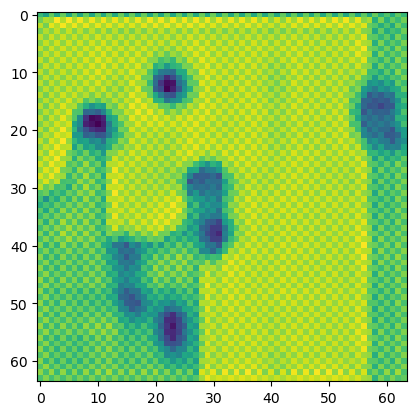

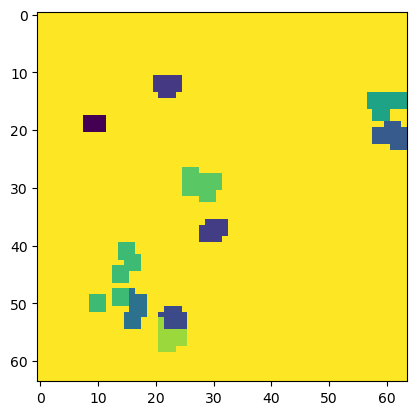

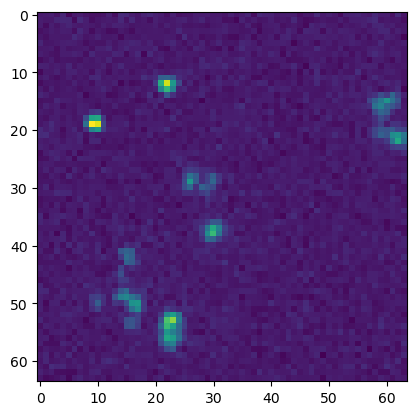

In [64]:
import matplotlib.pyplot as plt
plt.imshow(out_1[ :, :].detach().cpu().numpy())
plt.show()
plt.imshow(input_1[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(img_1[:,:].detach().cpu().numpy())

In [37]:
filename_m = dir_mask + 'mask_1.jpg'
mask = Image.open(filename_m)
mask2.max

<function Tensor.max>

'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-09-18/17-52/mask/mask_1.jpg'

In [14]:
from PIL import Image
filename = './data/imgs/0cdf5b5d0ce1_01.jpg'
img = Image.open(filename)

img2 = torch.from_numpy(BasicDataset.preprocess(None, img, 1, is_mask=False))

In [19]:
filename_m = './data/masks/fff9b3a5373f_14_mask.gif'
mask = Image.open(filename_m)
mask2 = torch.from_numpy(BasicDataset.preprocess([0,1], img, 1, is_mask=True))

In [20]:
mask2

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])